# Hypothesis Testing
## Overview
Let's say you know the mean and standard deviation of a population. How can you tell if a sample is from this population or some other population? Although we may never know with 100% certainty, we can look for statistically significant differences between the sample statistics and the population paramters. This is done by first stating what is refered to as a null hypothesis, which in this scenario would be that there is no difference between the sample mean and the population mean. Then we look for statistical evidence to accept or reject the null hypothesis. What if we don't know the population parameters? After this case study you will know:
* how to formulate a null hypothesis and alternative hypothesis for comparing a sample mean to a population mean.
* how to conduct a z-test using the z-statistic for the sample mean to gain statistical evidence to accept or reject the null hypothesis.
* how to one-sample, paired sample, and independent sample t-tests when the population standard deviation is unknown and must be estimated using the sample standard deviation.

The following cell will import the WineEnthusiast data set using pandas. The data is linked to above and is formated as a CSV (comma-separated-values) file. Such a file could be opened in Excel but here we simply load the file into a pandas data structure called a dataframe and print out the first couple rows of the dataframe.

In [1]:
# Essential Libraries
import os
import sys
import numpy as np
import pandas as pd
import datetime
import random

# Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_style("whitegrid");
sns.set_color_codes(palette='pastel');

# Statistics
from scipy import stats as stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

pd.set_option('display.float_format', lambda x: '%.3f' % x);
pd.set_option('display.max_columns', None);
pd.options.display.max_seq_items = 8000;
pd.options.display.max_rows = 8000;

import warnings
warnings.filterwarnings(action="ignore");

PROJECT_ROOT_DIR = "."
DATA_DIR = os.path.join(PROJECT_ROOT_DIR, "data")
IMAGE_DIR = os.path.join(PROJECT_ROOT_DIR, "img")

from IPython.display import Image
for d in [DATA_DIR, IMAGE_DIR]:
    if not os.path.exists(d):
        os.mkdir(d)
        
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_DIR, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from pprint import pprint

#This is a little recursive helper function converts all nested ndarrays to python list of lists so that pretty printer knows what to do.

def arrayToList(arr):
    if type(arr) == type(np.array):
        #If the passed type is an ndarray then convert it to a list and
        #recursively convert all nested types
        return arrayToList(arr.tolist())
    else:
        #if item isn't an ndarray leave it as is.
        return arr

#suppress exponential notation, define an appropriate float formatter
#specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.4f}'.format}, linewidth=120)

Read csv file

In [3]:
wine_data = pd.read_csv("winemag-data-130k-v2.csv", index_col=0)
wine_data.shape

(129971, 13)

Display 1st five rows

In [4]:
wine_data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,nan,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.000,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Display last 5 rows

#### Duplicates
First of all let's explore our data. On first look into data we can see that there are many duplicates, which we have to drop.

Let's see how many duplicates are in the data.

In [5]:
data = wine_data
print("Total number of examples: ", data.shape[0])
print("Number of examples with the same title and description: ", data[data.duplicated(['description','title'])].shape[0])

Total number of examples:  129971
Number of examples with the same title and description:  9983


We can see that there are almost 10k records with the same title and description. We should drop rows columns in order to get proper result.

In [6]:
data=data.drop_duplicates(['description','title'])
data=data.reset_index(drop=True)

#### Missing values.
Now, we will investigate our dataset in order to see how many missing values there is.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119988 entries, 0 to 119987
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                119929 non-null  object 
 1   description            119988 non-null  object 
 2   designation            85443 non-null   object 
 3   points                 119988 non-null  int64  
 4   price                  111593 non-null  float64
 5   province               119929 non-null  object 
 6   region_1               100428 non-null  object 
 7   region_2               46769 non-null   object 
 8   taster_name            95071 non-null   object 
 9   taster_twitter_handle  90542 non-null   object 
 10  title                  119988 non-null  object 
 11  variety                119987 non-null  object 
 12  winery                 119988 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 11.9+ MB


We see that there is huge number of missing values. Let's see how many percent.

In [8]:
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
region_2,73219,61.022
designation,34545,28.790
taster_twitter_handle,29446,24.541
taster_name,24917,20.766
region_1,19560,16.302
price,8395,6.997
province,59,0.049
country,59,0.049
variety,1,0.001
winery,0,0.000


The most missing values are in region, destination, tester name and price columns.

I'm worried the most about wines with NaN in price columns. We don't want to predict points for wines which price are undeclared. We will drop rows with NaN value in this column.

Usefulness of other columns will be investigate on the Feature extraction stage. Maybe that NaN values are meaningful for particular columns.

In [9]:
data=data.dropna(subset=['price'])
data=data.reset_index(drop=True)

In [10]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [11]:
resumetable(data)

Dataset Shape: (111593, 13)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,country,object,55,42,Portugal,US,US,2.740
1,description,object,0,111567,"This is ripe and fruity, a wine that is smooth...","Tart and snappy, the flavors of lime flesh and...","Pineapple rind, lemon pith and orange blossom ...",16.770
2,designation,object,32060,35776,Avidagos,NaN,Reserve Late Harvest,13.780
3,points,int64,0,21,87,87,87,3.660
4,price,float64,0,390,15.000,14.000,13.000,5.780
5,province,object,55,422,Douro,Oregon,Michigan,4.970
6,region_1,object,18013,1204,NaN,Willamette Valley,Lake Michigan Shore,7.800
7,region_2,object,65025,17,NaN,Willamette Valley,NaN,3.280
8,taster_name,object,23273,19,Roger Voss,Paul Gregutt,Alexander Peartree,3.450
9,taster_twitter_handle,object,27756,15,@vossroger,@paulgwine,NaN,3.290


## EDA
Let's start by looking at the distribution of points and prices of the wines.

In [12]:
# The function describe is focused on numerical features
# in this case are points and price
print("Statistics of numerical data: ")
print(data.describe())

Statistics of numerical data: 
          points      price
count 111593.000 111593.000
mean      88.414     35.621
std        3.099     42.104
min       80.000      4.000
25%       86.000     17.000
50%       88.000     25.000
75%       91.000     42.000
max      100.000   3300.000


Very interesting distribuition of Points and Price.

* We can see that the values of points are distributed between 80 and 100
* The price have a high difference between the values and a high standard deviation
* In prices, the IQR (Interquantil Range) is 25. The max value is 3300.

In [13]:
# Let's construct a function that shows the summary and density distribution of a numerical attribute:
def summary(x):
    x_min = data[x].min()
    x_max = data[x].max()
    Q1 = data[x].quantile(0.25)
    Q2 = data[x].quantile(0.50)
    Q3 = data[x].quantile(0.75)
    print(f'5 Point Summary of {x.capitalize()} Attribute:\n'
          f'{x.capitalize()}(min) : {x_min}\n'
          f'Q1                    : {Q1}\n'
          f'Q2(Median)            : {Q2}\n'
          f'Q3                    : {Q3}\n'
          f'{x.capitalize()}(max) : {x_max}')

    fig = plt.figure(figsize=(16, 10))
    plt.subplots_adjust(hspace = 0.6)
    sns.set_palette('pastel')
    
    plt.subplot(221)
    ax1 = sns.distplot(data[x], color = 'r')
    plt.title(f'{x.capitalize()} Density Distribution')
    
    plt.subplot(222)
    ax2 = sns.violinplot(x = data[x], palette = 'Accent', split = True)
    plt.title(f'{x.capitalize()} Violinplot')
    
    plt.subplot(223)
    ax2 = sns.boxplot(x=data[x], palette = 'cool', width=0.7, linewidth=0.6)
    plt.title(f'{x.capitalize()} Boxplot')
    
    plt.subplot(224)
    ax3 = sns.kdeplot(data[x], cumulative=True)
    plt.title(f'{x.capitalize()} Cumulative Density Distribution')
    
    plt.show()

In [14]:
# Let's construct a function to calculate outlier values
def CalcOutliers(df_num): 
    '''
    
    Leonardo Ferreira 20/10/2018
    Set a numerical value and it will calculate the upper, lower and total number of outliers
    It will print a lot of statistics of the numerical feature that you set on input
    
    '''
    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Identified outliers: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentage of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentage of outliers in points
    
    return

Let's start by investigating the 'points' variable.

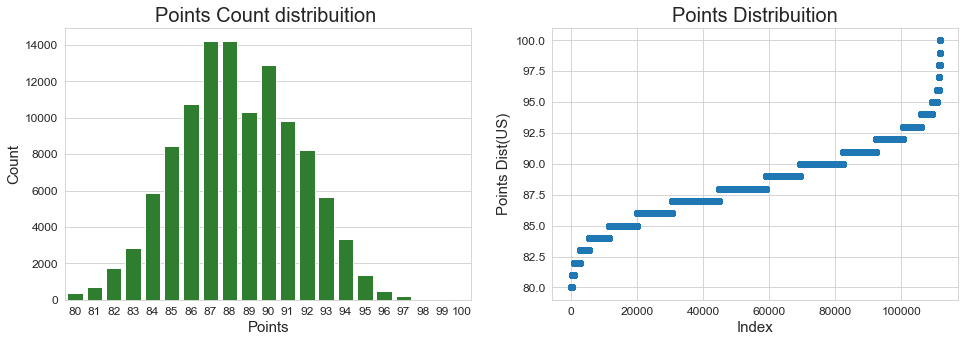

In [15]:
# define the size of figures that I will build
plt.figure(figsize=(16,5))

plt.subplot(1,2,1) # this will create a grid of 1 row and 2 columns; this is the first graphic
g = sns.countplot(x='points', data=data, color='forestgreen') # seting the seaborn countplot to known the points distribuition
g.set_title("Points Count distribuition ", fontsize=20) # seting title and size of font
g.set_xlabel("Points", fontsize=15) # seting xlabel and size of font
g.set_ylabel("Count", fontsize=15) # seting ylabel and size of font

plt.subplot(1,2,2)  # this will set the second graphic of our grid
plt.scatter(range(data.shape[0]), np.sort(data.points.values)) # creating a cumulative distribution
plt.xlabel('Index', fontsize=15)  # seting xlabel and size of font
plt.ylabel('Points Dist(US)', fontsize=15)  # seting ylabel and size of font
plt.title("Points Distribuition", fontsize=20) # seting title and size of font

plt.show() #rendering the graphs

Let's set the points into categories.
I will create a new feature containing the range of the points with a rank.

In [16]:
def cat_points(points):
    if points in list(range(80,83)):
        return 0
    elif points in list(range(83,87)):
        return 1
    elif points in list(range(87,90)):
        return 2
    elif points in list(range(90,94)):
        return 3
    elif points in list(range(94,98)):
        return 4
    else:
        return 5

data["rating_cat"] = data["points"].apply(cat_points)

### Plotting Rating categories
Let's see the distribution after the transformation.

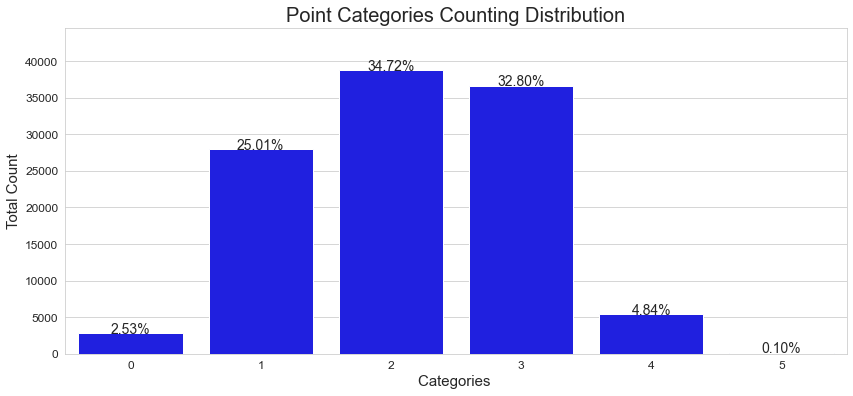

In [17]:
total = len(data)
plt.figure(figsize=(14,6))

g = sns.countplot(x='rating_cat', color='blue',
                  data=data)
g.set_title("Point Categories Counting Distribution", fontsize=20)
g.set_xlabel("Categories ", fontsize=15)
g.set_ylabel("Total Count", fontsize=15)

sizes=[]

for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 6,
            '{:1.2f}%'.format((height/total)*100),
            ha="center", fontsize=14) 
    
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

In [18]:
# Outlier points
CalcOutliers(data['points'])

Identified lowest outliers: 0
Identified upper outliers: 116
Identified outliers: 116
Non-outlier observations: 111477
Total percentage of Outliers:  0.1041


Now let's take a look at the price distribution.

5 Point Summary of Price Attribute:
Price(min) : 4.0
Q1                    : 17.0
Q2(Median)            : 25.0
Q3                    : 42.0
Price(max) : 3300.0


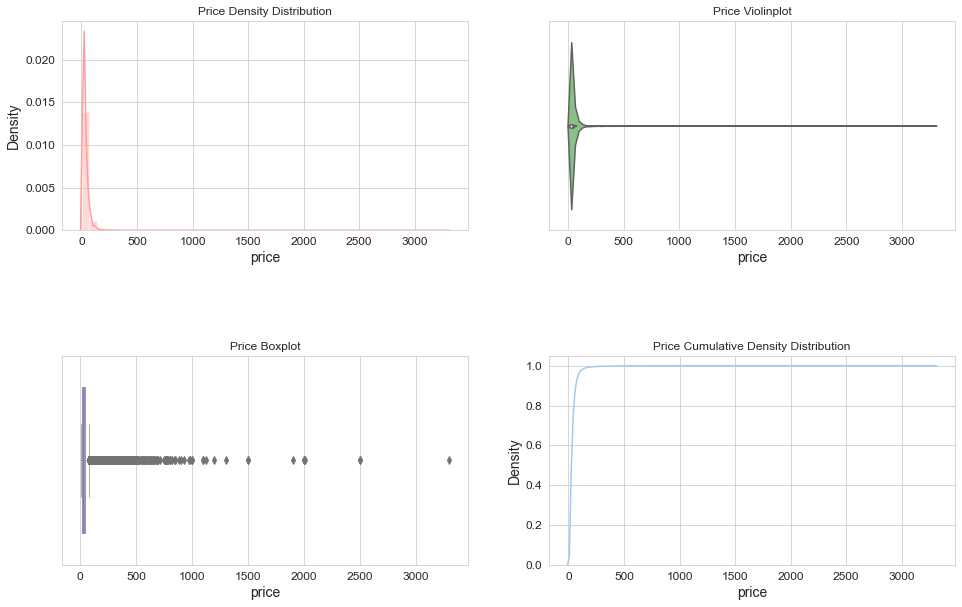

In [19]:
summary('price')

In [20]:
CalcOutliers(data['price'])

Identified lowest outliers: 0
Identified upper outliers: 1079
Identified outliers: 1079
Non-outlier observations: 110514
Total percentage of Outliers:  0.9763


Now we can clearly see that we have less than 1% of outliers, that is 1177 prices that is out of our IQR.
Let's se a filtered distribution of prices, where we only consider wines with price <= 300$.

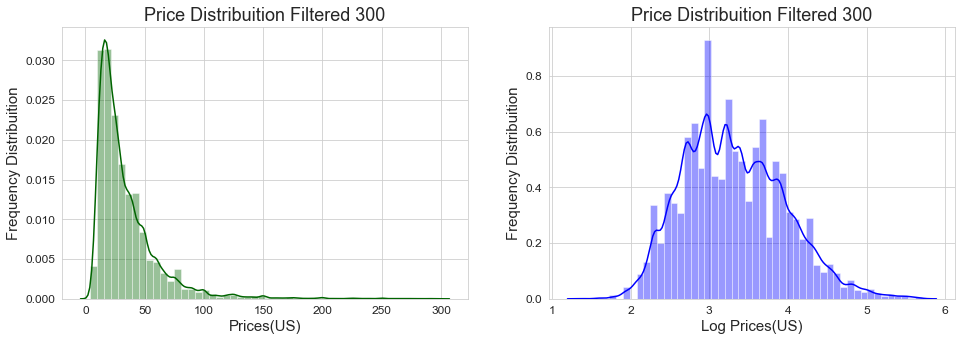

In [21]:
plt.figure(figsize=(16,5))

g = sns.distplot(data[data['price'] < 300]['price'], color='darkgreen')
g.set_title("Price Distribuition Filtered 300", fontsize=20)
g.set_xlabel("Prices(US)", fontsize=15)
g.set_ylabel("Frequency Distribuition", fontsize=15)

plt.subplot(1,2,1) # this will create a grid of 1 row and 2 columns; this is the first graphic
g = sns.distplot(data[data['price'] < 300]['price'], color='darkgreen')
g.set_title("Price Distribuition Filtered 300", fontsize=18)
g.set_xlabel("Prices(US)", fontsize=15)
g.set_ylabel("Frequency Distribuition", fontsize=15)

plt.subplot(1,2,2)  # this will set the second graphic of our grid
g = sns.distplot(np.log(data[data['price'] < 300]['price']), color='blue')
g.set_title("Price Distribuition Filtered 300", fontsize=18)
g.set_xlabel("Log Prices(US)", fontsize=15)
g.set_ylabel("Frequency Distribuition", fontsize=15)

plt.show()

In [22]:
# Let's get the price_log to better work with this feature
data['price_log'] = np.log(data['price'])

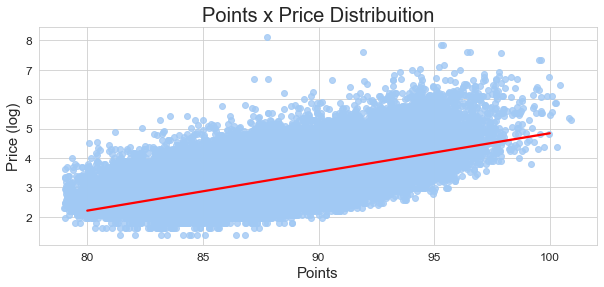

In [23]:
plt.figure(figsize=(10,4))

g = sns.regplot(x='points', y='price_log', 
                data=data, line_kws={'color':'red'},
                x_jitter=True, fit_reg=True)
g.set_title("Points x Price Distribuition", fontsize=20)
g.set_xlabel("Points", fontsize= 15)
g.set_ylabel("Price (log)", fontsize= 15)

plt.show()

### Observations:

* The highest prices isn't of the wine with highest pontuation.
* The most expensive wine have ponctuation between 87 and 90.

<AxesSubplot:xlabel='points', ylabel='price'>

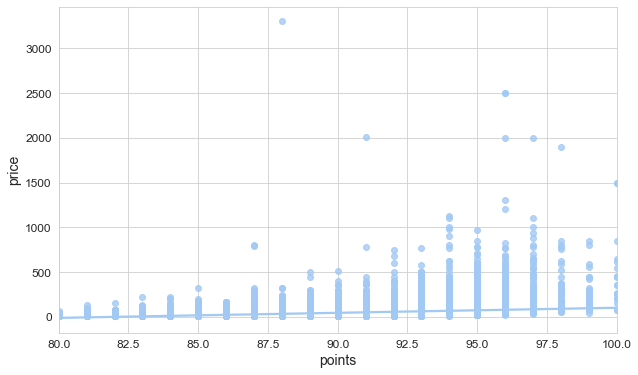

In [24]:
fig, ax = plt.subplots(figsize = (10, 6))
sns.regplot(x = 'points', y = 'price', data = data)

<AxesSubplot:xlabel='points', ylabel='price_log'>

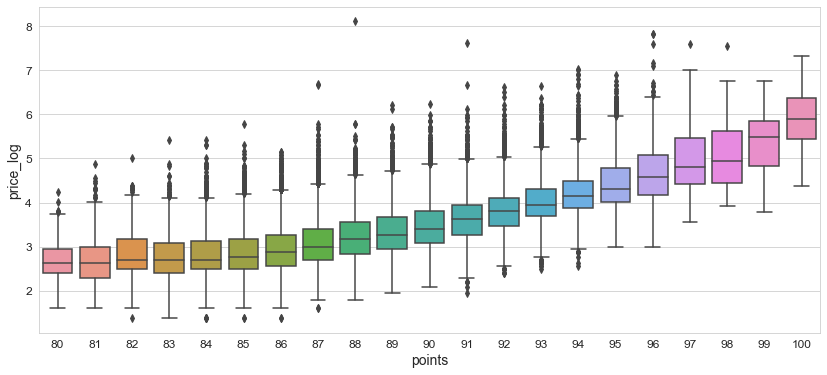

In [25]:
fig, ax = plt.subplots(figsize = (14, 6))
sns.boxplot(x = 'points', y = 'price_log', data = data)

In [26]:
data[data.price>=2000]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,rating_cat,price_log
14628,France,The wine is a velvet glove in an iron fist. Th...,NaN,96,2500.000,Bordeaux,Pomerol,NaN,Roger Voss,@vossroger,Château Pétrus 2014 Pomerol,Bordeaux-style Red Blend,Château Pétrus,4,7.824
58206,France,This extravagantly perfumed wine has great jui...,NaN,97,2000.000,Bordeaux,Pomerol,NaN,Roger Voss,@vossroger,Château Pétrus 2011 Pomerol,Bordeaux-style Red Blend,Château Pétrus,4,7.601
70922,France,This ripe wine shows plenty of blackberry frui...,NaN,88,3300.000,Bordeaux,Médoc,NaN,Roger Voss,@vossroger,Château les Ormes Sorbet 2013 Médoc,Bordeaux-style Red Blend,Château les Ormes Sorbet,2,8.102
86108,France,"A superb wine from a great year, this is power...",NaN,96,2500.000,Burgundy,La Romanée,NaN,Roger Voss,@vossroger,Domaine du Comte Liger-Belair 2010 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair,4,7.824
98425,France,"A wonderfully complete wine, with all the elem...",NaN,96,2000.000,Burgundy,La Romanée,NaN,Roger Voss,@vossroger,Domaine du Comte Liger-Belair 2005 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair,4,7.601
103926,US,The nose on this single-vineyard wine from a s...,Roger Rose Vineyard,91,2013.000,California,Arroyo Seco,Central Coast,Matt Kettmann,@mattkettmann,Blair 2013 Roger Rose Vineyard Chardonnay (Arr...,Chardonnay,Blair,3,7.607


In [31]:
variety = data.groupby("variety").points.count().sort_values(ascending = False)

variety
Pinot Noir                  11835
Chardonnay                  10238
Cabernet Sauvignon           8763
Red Blend                    7809
Bordeaux-style Red Blend     4958
Riesling                     4572
Sauvignon Blanc              4403
Syrah                        3778
Rosé                         2951
Merlot                       2856
Zinfandel                    2524
Malbec                       2391
Sangiovese                   2163
Nebbiolo                     2159
Portuguese Red               2028
White Blend                  2004
Sparkling Blend              1849
Tempranillo                  1651
Rhône-style Red Blend        1283
Pinot Gris                   1268
Name: points, dtype: int64

In [32]:
variety.index.tolist()[:20]

['Pinot Noir',
 'Chardonnay',
 'Cabernet Sauvignon',
 'Red Blend',
 'Bordeaux-style Red Blend',
 'Riesling',
 'Sauvignon Blanc',
 'Syrah',
 'Rosé',
 'Merlot',
 'Zinfandel',
 'Malbec',
 'Sangiovese',
 'Nebbiolo',
 'Portuguese Red',
 'White Blend',
 'Sparkling Blend',
 'Tempranillo',
 'Rhône-style Red Blend',
 'Pinot Gris']

In [33]:
top_variety = data[data['variety'].isin(variety.index.tolist()[:20])]

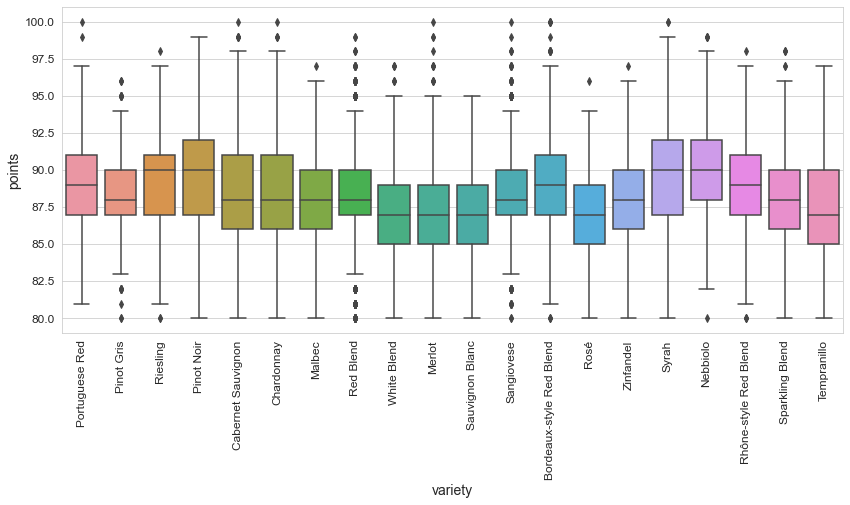

In [34]:
fig, ax = plt.subplots(figsize = (14, 6))
sns.boxplot(x = 'variety', y = 'points', data = top_variety)
plt.xticks(rotation=90)
plt.show()

In [35]:
data.groupby("taster_name").points.count().sort_values(ascending = False)

taster_name
Roger Voss            18543
Michael Schachner     13871
Kerin O’Keefe          8885
Paul Gregutt           8838
Virginie Boone         8682
Matt Kettmann          5643
Joe Czerwinski         4644
Sean P. Sullivan       4423
Anna Lee C. Iijima     3974
Jim Gordon             3761
Anne Krebiehl MW       3036
Lauren Buzzeo          1582
Susan Kostrzewa        1011
Mike DeSimone           452
Jeff Jenssen            436
Alexander Peartree      381
Carrie Dykes            128
Fiona Adams              24
Christina Pickard         6
Name: points, dtype: int64

In [36]:
data.groupby("taster_name").points.mean().sort_values(ascending = False)

taster_name
Anne Krebiehl MW     90.678
Matt Kettmann        90.088
Virginie Boone       89.224
Mike DeSimone        89.122
Paul Gregutt         89.099
Kerin O’Keefe        88.939
Sean P. Sullivan     88.756
Roger Voss           88.625
Jim Gordon           88.603
Joe Czerwinski       88.525
Anna Lee C. Iijima   88.406
Jeff Jenssen         88.330
Christina Pickard    87.833
Lauren Buzzeo        87.501
Michael Schachner    86.859
Fiona Adams          86.750
Susan Kostrzewa      86.588
Carrie Dykes         86.344
Alexander Peartree   85.780
Name: points, dtype: float64

In [37]:
data.groupby("taster_name").points.agg(["min","max","mean","count"])

,min,max,mean,count
taster_name,,,,
Alexander Peartree,80,91,85.780,381
Anna Lee C. Iijima,80,98,88.406,3974
Anne Krebiehl MW,80,97,90.678,3036
Carrie Dykes,81,92,86.344,128
Christina Pickard,82,93,87.833,6
Fiona Adams,82,91,86.750,24
Jeff Jenssen,82,97,88.330,436
Jim Gordon,80,97,88.603,3761
Joe Czerwinski,80,100,88.525,4644


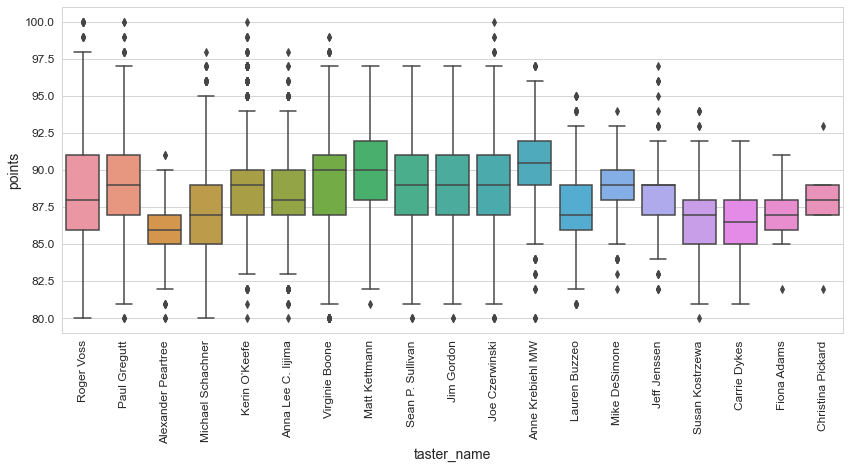

In [38]:
fig, ax = plt.subplots(figsize = (14, 6))
sns.boxplot(x = 'taster_name', y = 'points', data = data)
plt.xticks(rotation=90)
plt.show()

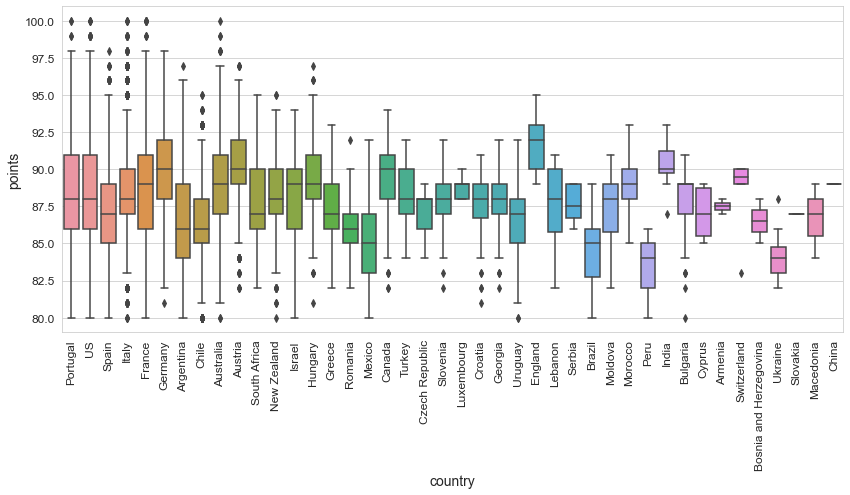

In [39]:
fig, ax = plt.subplots(figsize = (14, 6))
sns.boxplot(x = 'country', y = 'points', data = data)
plt.xticks(rotation=90)
plt.show()

In [40]:
top = data[data.points >= 95]
top.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,rating_cat,price_log
319,Australia,This wine contains some material over 100 year...,Rare,100,350.000,Victoria,Rutherglen,NaN,Joe Czerwinski,@JoeCz,Chambers Rosewood Vineyards NV Rare Muscat (Ru...,Muscat,Chambers Rosewood Vineyards,5,5.858
320,Australia,"This deep brown wine smells like a damp, mossy...",Rare,98,350.000,Victoria,Rutherglen,NaN,Joe Czerwinski,@JoeCz,Chambers Rosewood Vineyards NV Rare Muscadelle...,Muscadelle,Chambers Rosewood Vineyards,5,5.858
321,Germany,"Dusty, saffron-spiced earthiness is juxtaposed...",Kiedrich Gräfenberg Trockenbeerenauslese,97,775.000,Rheingau,NaN,NaN,Anna Lee C. Iijima,NaN,Robert Weil 2014 Kiedrich Gräfenberg Trockenbe...,Riesling,Robert Weil,4,6.653
322,Australia,Deep mahogany. Dried fig and black tea on the ...,Grand,97,100.000,Victoria,Rutherglen,NaN,Joe Czerwinski,@JoeCz,Chambers Rosewood Vineyards NV Grand Muscat (R...,Muscat,Chambers Rosewood Vineyards,4,4.605
323,Australia,"RunRig is always complex, and the 2012 doesn't...",RunRig,97,225.000,South Australia,Barossa,NaN,Joe Czerwinski,@JoeCz,Torbreck 2012 RunRig Shiraz-Viognier (Barossa),Shiraz-Viognier,Torbreck,4,5.416


In [41]:
bottom = data[data.points <= 85]
bottom.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,rating_cat,price_log
45,Chile,This is much different than Casa Silva's 2009 ...,Gran Reserva,85,22.000,Colchagua Valley,NaN,NaN,Michael Schachner,@wineschach,Casa Silva 2008 Gran Reserva Petit Verdot (Col...,Petit Verdot,Casa Silva,1,3.091
46,Italy,The Monica grape often shows a rustic or raw q...,Dolia,85,14.000,Sicily & Sardinia,Monica di Sardegna,NaN,NaN,NaN,Cantine di Dolianova 2010 Dolia (Monica di Sa...,Monica,Cantine di Dolianova,1,2.639
47,France,"Fruity and lightly herbaceous, this has fine t...",La Fleur d'Amélie,85,15.000,Bordeaux,Bordeaux Blanc,NaN,Roger Voss,@vossroger,Château de Sours 2011 La Fleur d'Amélie (Bord...,Bordeaux-style White Blend,Château de Sours,1,2.708
48,US,This shows jelly-like flavors of orange and pe...,Estate Bottled,85,30.000,California,Napa Valley,Napa,NaN,NaN,RustRidge 2010 Estate Bottled Chardonnay (Napa...,Chardonnay,RustRidge,1,3.401
49,US,"This is weighty, creamy and medium to full in ...",NaN,85,14.000,California,North Coast,North Coast,Virginie Boone,@vboone,Souverain 2010 Chardonnay (North Coast),Chardonnay,Souverain,1,2.639


In [43]:
!pip install wordcloud

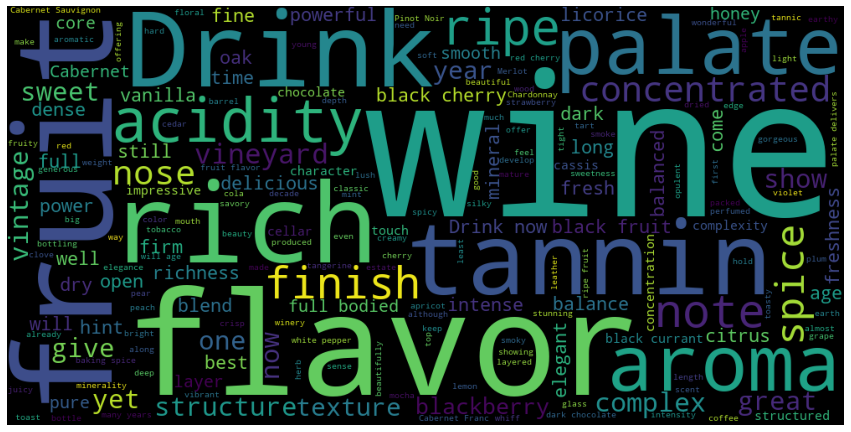

In [44]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(top.description))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

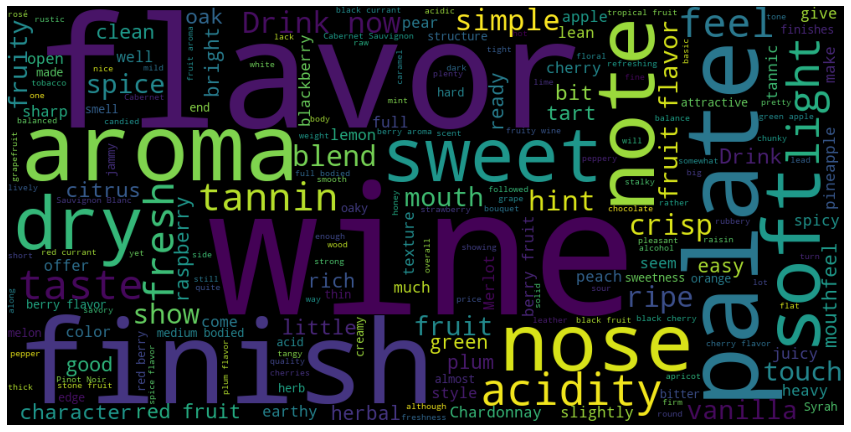

In [45]:
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(bottom.description))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Looking at the words that are mostly used in the reviews of the highest rated wines (>=95 points) and the lowest rated wines (<=85 points) the results are not very informative. If we exclude the basic common words (e.g. wine) or the neutral words (e.g. note), the 3 words that mostly appear in the higher rated wines are: fruit, tannin, rich. For the lower rated wines the words are: dry, sweet, light/simple.

## Hypothesis Testing
### Samples of Wine scores and prices From the Wine Population
Let's assume the WineEnthusiast point scores are interval-scaled normally distributed data. Let's find the population mean and population standard deviation.

In [46]:
points = data['points']
mu = points.mean()
sigma = points.std(ddof=0)
print("mu: ", mu, ", sigma:", sigma)

mu:  88.41396861810328 , sigma: 3.098753249147861


### 1 Sample z test

#### Prob 1. A sample of N=10 wine point scores yields a sample mean of x_bar = 90.2. Is this sample from the WineEnthusiast population? 
To test this question we will use what is refered to as a one-sample z-test. First we state the null hypothesis and alternative hypothesis like this;
* H<sub>0</sub>: The sample is from the WineEnthusiast population, x_bar = &mu;.
* H<sub>A</sub>: The sample is not from the WineEnthusiast population, x_bar != (not equal) &mu;.

Then, we specify a significance (alpha) level. Usually, statistical significance is associated with an alpha level of &alpha; = 0.05 or smaller. Next, we use a [z table](http://www.stat.ufl.edu/~athienit/Tables/Ztable.pdf) to look up the critical z value that cooresponds to this &alpha; level. Here we are doing a two-tailed test because we don't care if the sample mean is greater than or less than the population mean. We just are testing to see if the two are equal or notl (see the alternative hypothesis above). Next we calculate the z-statitic for the sample mean compared to the population mean dividing by the standard deviation of the sample mean, which is the standard error &sigma;/sqrt(N). If this z-statistic is less than z-critical then we accept the null hypothesis, otherwise we reject the null and accept the alternative hypothesis. Let's do it.

In [47]:
z_critical = 1.96 # alpha level of 0.05 and two-tailed test
x_bar = 90.2
N = 10
SE = sigma/np.sqrt(N)
z_stat = (x_bar - mu)/SE
print(z_stat)

1.822645007596137


Since z_stat is less than z_critical we fail to reject the null hypothesis and reject the althernative. Statistically, we say the sample mean is no different than the population mean and thus the sample is drawn from the population. But what if the sample size was larger? Let's redo the calculation with N=30.

In [48]:
N = 30;
SE = sigma/np.sqrt(N)
z_stat = (x_bar - mu)/SE
print(z_stat)

3.1569137573182715


Now the z-statistic is greater than z-critical and we reject the null hypothesis. Statistically speaking we say that this sample was drawn from some different population than the WineEnthusiast population. Why the difference? As you can see mathematically, increasing the sample size decreases the standard error of the sample mean. This means the distribution of sample means becomes narrower as N gets larger and thus it is less likely to overlap with the population mean everything else being equal.

## T-Tests
Around 1900, a chemist and statistical wizard named William Sealy Gosset who went by the pen name Student worked for the Guiness Brewery in Ireland. in his mission to use science to make better beer, he noticed that in situations where the population standard deviation is unknown (most situations), it can be estimated using the sample standard deviation (using the unbiased version normalized by N-1). But, if the sample size is small (let's say less than 30 is small) the shape of the distribution of sample means has thicker tails than a normal distribution because there is more variability in the estimate of the standard deviation of the sample mean (the standard error), which itself depends on the sample size. Thus, the z-test is unreliable because z-values are determend using a normal distribuiton. Instead, we must draw our test statistic from a different distribution called the t-distribution. The shape of this distribution narrows and becomes more normal like and the sample size increases or degrees of freedom increases, where degrees of freedom is N-1. Thus, Student's t-test is conducted in a fashion similar to a z-test but the t-statistic is pulled from a different distribution and thus a different table. **The t-statistic itself has a similar form to the z-statistic in that it is a ration of a deviation divided by a measure of variability.** However, the exact for of the ratio for the t-statistic depends on the nature of the data being used. Next I'll show you how to apply Student's t-test to various experimental scenarios.

## Framework for Statistical Hypothesis Testing with T-Tests
* Do you have one sample that you want to compare to some spcified value? Do a **one-sample t-test**. For example, let's say it is well known that acorns have an average mass of 10 g, and you want to test to see if them mass of acorns from a forest subjected to acid rain are signifcantly different. 
* Do you have two independent samples that you want to compare to each other? Do an **independent samples t-test**. For example, let's say you take samples of acorn from a forest upwind and downwind from a coal power plant and you want to test to see if the average mass of the acorns from the two samples is the same.
* Do you have two dependent samples taken from the same indidividuals or objects? Do a **paired samples t-test**. For example, let's say you measure the average mass of acorns from 50 trees in a forest before and after the local power plant converted from coal to natural gas and want to see if there is a difference in the masses pre-conversion to post-conversion. 

### One-sample location test on whether the mean of a population is equal to a value specified in null hypothesis
#### Problem 2. Suppose you take 50 random samples from the filtered wine population with wine rating category 2, 3 and 4 respectively. Is the average price of the samples of 2nd category wines significantly different from the average price of the wine population?
* H<sub>0</sub>: x&#772; - &mu; = 0, that is there is no difference between my sample mean and the value of &mu;.
* H<sub>a</sub>: x&#772; - &mu; &ne; 0 (two-sided test)
* &alpha; = 0.05

[t-table](http://www.sjsu.edu/faculty/gerstman/StatPrimer/t-table.pdf)
* degrees of freedom: d<sub>f</sub> = N-1
* t-critical for specified alpha level: t<sub>*</sub> = 2.093
* t-statistic: t = (x&#772; - &mu;)/(s/sqrt(N)) where s is the sample standard deviation.

In [49]:
df1 = data[data['rating_cat'] == 2].sample(n = 50)
df2 = data[data['rating_cat'] == 3].sample(n = 50)
df3 = data[data['rating_cat'] == 4].sample(n = 50)

In [50]:
price = data[data['price'] <= 300].price
mu = price.mean()
sigma = price.std(ddof=0)
print("mu: ", mu, ", sigma:", sigma)

mu:  34.24166749040717 , sigma: 27.83921898533953


In [51]:
x = df1['price'].tolist()
mu = 34.24166749040717 
t_critical = 2.093
x_bar = np.array(x).mean()
s = np.array(x).std(ddof=1) # subtract 1 from N to get unbiased estimate of sample standard deviation
N = len(x)
SE = s/np.sqrt(N)
t = (x_bar - mu)/SE
print("t-statistic: ",t)

# a one sample t-test that gives you the p-value too can be done with scipy as follows:
t, p = stats.ttest_1samp(x, mu)
print("t = ", t, ", p = ", p)

t-statistic:  -2.2865788565166785
t =  -2.2865788565166785 , p =  0.02658020737769558


We fail to reject the null Hypothesis that the average price the sample is significantly different from the average price of the wine population.

#### Problem 3. The mass of a sample of N=20 acorns from a forest subjected to acid rain from a coal power plant are m = 8.8, 6.6, 9.5, 11.2, 10.2, 7.4, 8.0, 9.6, 9.9, 9.0, 7.6, 7.4, 10.4, 11.1, 8.5, 10.0, 11.6, 10.7, 10.3, and 7.0 g. Is the average mass of this sample different from the average mass of all acorns of &mu; = 10.0 g?

* H<sub>0</sub>: x&#772; - &mu; = 0, that is there is no difference between my sample mean and the value of &mu;.
* H<sub>a</sub>: x&#772; - &mu; &ne; 0 (two-sided test)
* &alpha; = 0.05

[t-table](http://www.sjsu.edu/faculty/gerstman/StatPrimer/t-table.pdf)
* degrees of freedom: d<sub>f</sub> = N-1
* t-critical for specified alpha level: t<sub>*</sub> = 2.093
* t-statistic: t = (x&#772; - &mu;)/(s/sqrt(N)) where s is the sample standard deviation.


In [52]:
x = [8.8, 6.6, 9.5, 11.2, 10.2, 7.4, 8.0, 9.6, 9.9, 9.0,
     7.6, 7.4, 10.4, 11.1, 8.5, 10.0, 11.6, 10.7, 10.3, 7.0]
mu = 10
t_critical = 2.093
x_bar = np.array(x).mean()
s = np.array(x).std(ddof=1) # subtract 1 from N to get unbiased estimate of sample standard deviation
N = len(x)
SE = s/np.sqrt(N)
t = (x_bar - mu)/SE
print("t-statistic: ",t)

# a one sample t-test that gives you the p-value too can be done with scipy as follows:
t, p = stats.ttest_1samp(x, mu)
print("t = ", t, ", p = ", p)

t-statistic:  -2.2491611580763977
t =  -2.2491611580763973 , p =  0.03655562279112415


Note that t is greater in magnitude that t<sub>*</sub> so there is a statistically significant difference at the &alpha; = 0.05 level between the sample mean and the stated population mean of 10 g. Note that statistical signficance doesn mean the effect is large. Let's report the 95% confidence intervals too.. 

In [53]:
# margin of error
err = t_critical*SE
x_low = x_bar - err
x_high = x_bar + err
print("x_bar = {}, 95% CI [{}, {}]".format(x_bar.round(2), x_low.round(2), x_high.round(2)))

# you can also get CIs by using the build int t-distribution function like this:
print("CI using scipy: ",stats.t.interval(0.95, N-1, loc=x_bar, scale=SE))

x_bar = 9.24, 95% CI [8.53, 9.95]
CI using scipy:  (8.532759313560822, 9.947240686439175)


### Independent (unpaired) two-sample location test with a null hypothesis that the means of the two samples are equal (equal variance assued).
#### Problem 4. The mass of N<sub>1</sub>=20 acorns from oak trees up wind from a coal power plant and N<sub>2</sub>=30 acorns from oak trees down wind from the same coal power plant are mesured. Are the acorns from trees downwind less massive then the ones from up wind? 

This will require a one-tail (on the low/left side) test. The sample sizes are not equal but we will assume that the population variance of sample 1 and sample 2 are equal. If we don't make the assumption of equal variance then we do a Welch's t-test.

* H<sub>0</sub>: x&#772;<sub>1</sub> = x&#772;<sub>2</sub>, or x&#772;<sub>2</sub> - x&#772;<sub>1</sub> = 0, that is , there is no difference between the sample means
* H<sub>A</sub>: x&#772;<sub>2</sub> < x&#772;<sub>1</sub>, or x&#772;<sub>2</sub> - x&#772;<sub>1</sub> < 0
* &alpha; = 0.05

[t-table](http://www.sjsu.edu/faculty/gerstman/StatPrimer/t-table.pdf)
* degrees of freedom: d<sub>f1</sub>= N<sub>1</sub>-1 = 19, d<sub>f2</sub>= N<sub>2</sub>-1 = 29, d<sub>f</sub> = d<sub>f1</sub> + d<sub>f2</sub> = N<sub>1</sub> + N<sub>2</sub> - 2 = 48

* t-critical for specified alpha level: t<sub>*</sub> = -1.677 (one-tailed, left-side)
* t-statistic: t = (x&#772;<sub>2</sub> - x&#772;<sub>1</sub>)/(s<sub>p</sub> sqrt(1/N<sub>1</sub> + 1/N<sub>2</sub>)))
* pooled variance: s<sub>p</sub> = sqrt( ((d<sub>1</sub>) s<sub>1</sub><sup>2</sup> + (d<sub>2</sub>) s<sub>2</sub><sup>2</sup>)) / d<sub>f</sub> )


In [54]:
# sample up wind
x1 = [10.8, 10.0, 8.2, 9.9, 11.6, 10.1, 11.3, 10.3, 10.7, 9.7, 
      7.8, 9.6, 9.7, 11.6, 10.3, 9.8, 12.3, 11.0, 10.4, 10.4]

# sample down wind
x2 = [7.8, 7.5, 9.5, 11.7, 8.1, 8.8, 8.8, 7.7, 9.7, 7.0, 
      9.0, 9.7, 11.3, 8.7, 8.8, 10.9, 10.3, 9.6, 8.4, 6.6,
      7.2, 7.6, 11.5, 6.6, 8.6, 10.5, 8.4, 8.5, 10.2, 9.2]

# equal sample size and assume equal population variance
t_critical = 1.677
N1 = len(x1)
N2 = len(x2)
d1 = N1-1
d2 = N2-1
df = d1+d2
s1 = np.std(x1,ddof=1)
s2 = np.std(x2,ddof=1)
x1_bar = np.mean(x1)
x2_bar = np.mean(x2)

sp = np.sqrt((d1*s1**2 + d2*s2**2)/df)
se = sp*np.sqrt(1/N1 + 1/N2)
t = (x2_bar - x1_bar)/(se)
print("t-statistic", t)

# a two-sample independent t-test is done with scipy as follows
# NOTE: the p-value given is two-sided so the one-sided p value would be p/2
t, p_twosided = stats.ttest_ind(x2, x1, equal_var=True)
print("t = ",t, ", p_twosided = ", p_twosided, ", p_onesided =", p_twosided/2)

t-statistic -3.5981947686898033
t =  -3.5981947686898033 , p_twosided =  0.0007560337478801464 , p_onesided = 0.0003780168739400732


## Estimating Effect Size
Since the t-statistic above is less than t-critical, the null is rejected and the alternative hypothesis is accepted. Just because there is a statistically significant difference betwee the two samples doesn't necessaily mean the differene is meaningful. Let's calculate the 95% confidence interval and a measure of effect size, Cohen's d.. 
* Cohen's d, d = (mean deviation) / (pooled standard deviation) = (x&#772;<sub>2</sub> - x&#772;<sub>1</sub>) / s<sub>p</sub>

We can also calculate a correlation of determination r<sup>2</sup> which represents the fraction of the variance in the data explained by the sample  it belongs to. 

* Coefficient of determination, r<sup>2</sup> = t<sup>2</sup> / ( t<sup>2</sup> + df )

Confidence Interval:
x2_bar - x1_bar =  -1.3350000000000026 , 95% CI  (-2.0809844644533113, -0.589015535546694)
Cohen's Effect Size, d:
d =  -1.0387093591498806
r_squared =  0.21243054465702976
r_squared =  0.2124305446570291


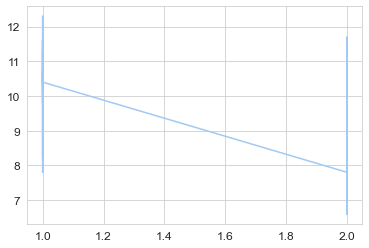

In [55]:
print("Confidence Interval:")
print("x2_bar - x1_bar = ", x2_bar - x1_bar, ", 95% CI ",stats.t.interval(0.95, df, loc=x2_bar-x1_bar, scale=se))
print("Cohen's Effect Size, d:")
print("d = ", (x2_bar - x1_bar)/sp)

rsq = t**2 / (t**2 + df)
print("r_squared = ", rsq) # 34.5 % of the variation between samples can be explained by the switch to nat. gas

# notice that the r_squared value above is equal to the r_squared value you would get from linear regression
x = np.concatenate((np.ones(N1), np.ones(N2)*2))
y = np.concatenate((x1,x2))

slope, yint, r, p, sterr = stats.linregress(x, y)
print("r_squared = ",r**2)

plt.plot(x,y)
plt.show()

## Paired samples (dependent/repeated measures) t-test with a null hypothesis that the mean difference is a specified constant (usually zero).
#### Prob 5. The average mass of acorns from the same N=30 trees downwind of a power plant is measured before (x<sub>1</sub>) and after (x<sub>2</sub>) the power plant converts from burning coal to buring natural gas. Does the mass of the acorns increase after the conversion from coal to natural gas? 

This will require a one-tail (on the low/left side) test.

* H<sub>0</sub>: x&#772;<sub>2</sub> - x&#772;<sub>1</sub> = 0, that is , there is no difference between the sample means
* H<sub>A</sub>: x&#772;<sub>2</sub> - x&#772;<sub>1</sub> > 0
* &alpha; = 0.05

[t-table](http://www.sjsu.edu/faculty/gerstman/StatPrimer/t-table.pdf)
* degrees of freedom: d<sub>f</sub> = N-1 = 29
* t-critical for specified alpha level: t<sub>*</sub> = 1.677 (one-tailed, right-side)
* t-statistic: t = (x&#772;<sub>diff</sub> - 0)/(s<sub>diff</sub> / sqrt(N))
* standard deviation of difference: s<sub>d</sub> = sqrt(s<sub>1</sub><sup>2</sup>/N<sub>1</sub> + s<sub>2</sub><sup>2</sup>/N<sub>2</sub>)
* mean difference: x&#772;<sub>diff</sub> = x&#772;<sub>2</sub> - x&#772;<sub>1</sub>

In [56]:
# sample before conversion to nat. gas
x1 = np.array([10.8, 6.4, 8.3, 7.6, 11.4, 9.9, 10.6, 8.7, 8.1, 10.9,
      11.0, 11.8, 7.3, 9.6, 9.3, 9.9, 9.0, 9.5, 10.6, 10.3,
      8.8, 12.3, 8.9, 10.5, 11.6, 7.6, 8.9, 10.4, 10.2, 8.8])
# sample after conversion to nat. gas
x2 = np.array([10.1, 6.9, 8.6, 8.8, 12.1, 11.3, 12.4, 9.3, 9.3, 10.8,
      12.4, 11.5, 7.4, 10.0, 11.1, 10.6, 9.4, 9.5, 10.0, 10.0,
      9.7, 13.5, 9.6, 11.6, 11.7, 7.9, 8.6, 10.8, 9.5, 9.6])
N = len(x2)
xbar_diff = np.mean(x2) - np.mean(x1) # could also do np.mean(x2 - x1))
sdiff = np.std(x2-x1,ddof=1)
t = xbar_diff / (sdiff/np.sqrt(N))
print("t = ", t)

t, p = stats.ttest_rel(x2, x1) # using scipy
print("t = ", t, ", p = ", p/2) # divide by two because we are doing a one-tail test

d = xbar_diff / sdiff
print("d = ", d) # chohen's d

t =  3.9054390813265063
t =  3.905439081326491 , p =  0.0002584344912342189
d =  0.7130323606015934


So, there is a statistically significant difference between the two samples at the &alpha; = 0.05 level. 



We have the potato yield from 12 different farms. We know that the standard potato yield for the given variety is µ=20.

x = [21.5, 24.5, 18.5, 17.2, 14.5, 23.2, 22.1, 20.5, 19.4, 18.1, 24.1, 18.5]

Test if the potato yield from these farms is significantly better than the standard yield.



Step 1: Define the Null and Alternate Hypothesis

H0: x̅ = 20

H1: x̅ > 20

n = 12. Since this is one sample T test, the degree of freedom = n-1 = 12-1 = 11.

Let’s set alpha = 0.05, to meet 95% confidence level.

In Python, One sample T Test is implemented in ttest_1samp() function in the scipy package. However, it does a Two tailed test by default, and reports a signed T statistic. That means, the reported P-value will always be computed for a Two-tailed test. To calculate the correct P value, you need to divide the output P-value by 2.

In [57]:
from scipy.stats import ttest_1samp
x =  [21.5, 24.5, 18.5, 17.2, 14.5, 23.2, 22.1, 20.5, 19.4, 18.1, 24.1, 18.5]
tscore, pvalue = ttest_1samp(x, popmean=20)
print("t Statistic: ", tscore)  
print("P Value: ", pvalue)

t Statistic:  0.2006562773994862
P Value:  0.8446291893053613


Since it is one tailed test, the real p-value is 0.8446/2 = 0.4223. We fail to reject the Null Hypothesis.

## Analysis of variance (ANOVA)

ANOVA is a hypothesis testing technique tests the equality of two or more population means by examining the variances of samples that are taken.

ANOVA tests the general rather than specific differences among means.

### Assumptions of ANOVA

* All populations involved follow a normal distribution
* All populations have the same variance
* The samples are randomly selected and independent of one another.

#### Problem 5. Suppose you take 50 random samples from the filtered wine population with wine rating category 2, 3 and 4 respectively. Is the average price of the samples from different categories differ significantly from each other?

#### Step 1: State the null and alternative hypothesis
* $H_0$: $\mu_0$ = $\mu_1$ = $\mu_2$
* $H_A$: Atleast one of the means are different.

Where:
 - $\mu_i$ = Population mean of BMI of prices of category 2, 3 and 4.
 
#### Step 2: Select an appropriate statistical test and the corresponding test statistic
We select one way ANOVA as our test and average price of the different groups as our test statistic.
#### Step 3: Choose level of significance α
We select α = 0.05.
#### Step 4: Collect data and calculate the value of test statistic
Here we have 3 groups. Analysis of variance can determine whether the means of three or more groups are different. ANOVA uses F-tests to statistically test the equality of means.

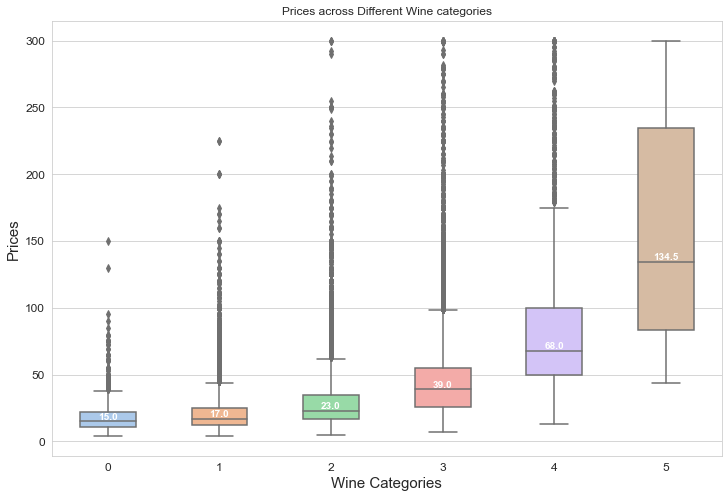

In [58]:
# Visualizing the collected data:
data = data[data['price'] <= 300]
fig = plt.figure(figsize=(12, 8))
box_plot = sns.boxplot(x = "rating_cat", y = "price", data = data, width = 0.5)

medians = data.groupby(['rating_cat'])['price'].median().round(2)
vertical_offset = data['price'].median() * 0.05 # offset from median for display

medians
for xtick in box_plot.get_xticks():
    box_plot.text(xtick, medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',color='w',weight='semibold')


plt.title('Prices across Different Wine categories')
plt.xlabel('Wine Categories', fontsize=15)  # seting xlabel and size of font
plt.ylabel('Prices', fontsize=15)  # seting ylabel and size of font
plt.show()

In [59]:
frames = [df1, df2, df3]
df = pd.concat(frames)
df.shape

(150, 15)

#### Step 5: Calculate p value using ANOVA table
* <code>statsmodels.formula.api.ols</code> creates a model from a formula and dataframe
* <code>statsmodels.api.sm.stats.anova_lm</code> gives an Anova table for one or more fitted linear models.

In [60]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols('price ~ rating_cat', data = df).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

               sum_sq      df      F  PR(>F)
rating_cat  90360.360   1.000 42.564   0.000
Residual   314191.480 148.000    nan     nan


### Step 6: Conclusion:
 - We <b>Reject</b> the null hypothesis that  average price of the samples from different categories are the same.
 - Hence, the distribution of price across different categories of wine are different.